## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 10: Spatio-temporal Gassusian Process (STGP) with Physical Models

A fundamental problem for Gaussian Process is that, many common covariance functions will miss spatial teleconnections such as those associated with sea-level fingerprints or large-scale climate modes, because they assume that correlation decays with distance.

This problem can be efficiently improved by incorporating physical models, which can  add potential information in the open ocean, far from tide gauge sites, whereas purely statistical models lose power away from the data. 

So in this tutorial, we will use a Gaussian Process model along with a glacial isostatic adjustment model to see the difference caused by incorporation of physical models.

This tutorial will be presented in the following order:

**&#10148; 1.** STGP without physical model for Holocene sea-level data

**&#10148; 2.** STGP with a single physical model for Holocene sea-level data

**&#10148; 3.** STGP with multiple physical models for Holocene sea-level data (Advance)

### 1. STGP without physical model for Holocene sea-level data

As in tutorial 8, we will use sea-level data from Ashe et al., (2019, and references therein) to infer spatio-temporal sea-level change pattern. Unlike tutorial 8 that used a single ST kernel, we will use multiple ST kernels here to decompose different physical processes contribution to sea-level change.


In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os
import time
from scipy import interpolate
sys.path.append('../../Code')
import PSTHM 
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

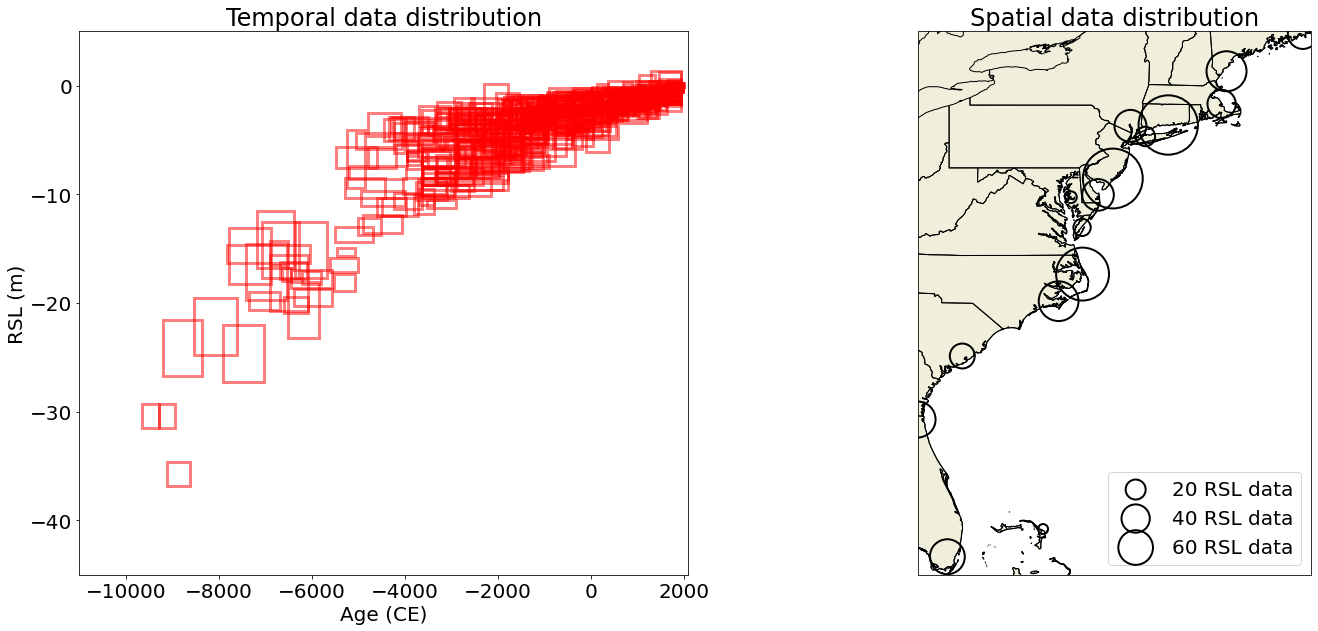

In [2]:
#load data
#ml is marine limiting data, tl is terrestrial limiting data, SLIP is sea-level index points
ml, SLIP, tl = PSTHM.load_regional_rsl_data('../../Data/US_Atlantic_Coast_for_ESTGP.csv')
age, y, y_sigma, age_sigma, rsl_lon,rsl_lat, rsl_region = SLIP
#define input matrix
rsl_coord = torch.tensor(np.vstack((rsl_lat,rsl_lon)).T)
X = torch.hstack([age[:,None],rsl_coord]) 

#--------Plot data distribution----------------
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, :1])
PSTHM.plot_uncertainty_boxes(age,y, age_sigma*2,y_sigma*2,ax=ax)
ax.set_xlim(-11000,2100)
ax.set_ylim(-45,5)
ax.set_title('Temporal data distribution')

#plot spatial data distribution, note that the size of the circle is proportional to the number of data points in the region
ax2 = fig.add_subplot(gs[0, 1:2], projection=ccrs.PlateCarree())

ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(rsl_lon),np.max(rsl_lon),np.min(rsl_lat),np.max(rsl_lat)])
rsl_region_index = [np.where(rsl_region==i)[0] for i in np.unique(rsl_region)]
ax2.scatter([np.mean(rsl_lon[x]) for x in rsl_region_index], [np.mean(rsl_lat[x]) for x in rsl_region_index],
           transform=ccrs.PlateCarree(),s=[len(x)*20 for x in rsl_region_index],marker='o',facecolor='none',ec='k',
           linewidth=2)
sc = ax2.scatter([0],[0],s=400,label='20 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc2 = ax2.scatter([0],[0],s=800,label='40 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc3 = ax2.scatter([0],[0],s=1200,label='60 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)

ax2.legend(handles=[sc,sc2,sc3], labels=['20 RSL data','40 RSL data','60 RSL data'], loc = 4)

ax2.set_title('Spatial data distribution');

In specific, we will use a global temporal kernel, a regionally linear ST kernel, a regional non-linear ST kernel, a locally non-linear ST kernel and a whitenoise kernel. We can write it down as:

$$
p(f| \Theta_{s},f ) \sim GP(0,k_{combined}(X,X')) \\
k_{combined}(X,X') = k_{global}(t,t') + k_{regionL}(X,X')  + k_{regionNL}(X,X') + k_{localNL}(X,X') + k_{whitenoise}(t,t')$$
where $X$ indicates time and location of each sea-level data, consisting time ($t$) and location ($x$). Each specific kernel can be expressed as: 
$$
k_{global}(t,t') = k_{M_{32}}(t,t')\\
k_{regionL}(X,X') = k_{Linear}(t,t') \cdot k_{RBF}(x,x')\\
k_{regionNL}(X,X') = k_{M_{52}}(t,t') \cdot k_{M_{32}}(x,x')\\
k_{localNL}(X,X') = k_{M_{32}}(t,t') \cdot k_{M_{32}}(x,x')\\
k_{whitenoise}(t,t') = k_{whitenose}(t,t')\\
$$
where $\cdot$ indicates element-wise multiplication. The difference between regional and local non-linear kernel is specified by different choices in kernels and prior distribtuions. 

**P.S.** 

1. The default code does not train the model, instead, it will load the trained model, which is much faster. If you want to try to train it on your own computer, just de-comment the code. 

2. To use GPU to accelerate the training process with `SVI_NI_optm` function, we need to specific `gpu==True` as well. 

In [3]:
# st = time.time() 

# pyro.clear_param_store()
# #define global temporal kernel as a Matern32
# global_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(5000.), torch.tensor(1000000.)))
# global_kernel.set_prior("variance", dist.Uniform(torch.tensor(40.**2), torch.tensor(100000.)))

# #define regionally linar spatio-temporal kernel
# regional_linear_temporal_kernel = gp.kernels.Linear(input_dim=1)
# regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-12), torch.tensor(10.)))
# regional_linear_spatial_kernel = PSTHM.RBF(input_dim=1,geo=True)
# regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(0.3)))
# regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

# #define regionally non-linar spatio-temporal kernel
# regional_nl_temporal_kernel = PSTHM.Matern52(input_dim=1,geo=False)
# regional_nl_temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1000.), torch.tensor(5000.)))
# regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.05), torch.tensor(40.**2)))
# regional_nl_spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
# regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(0.3)))
# regional_nl_kernel = gp.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

# #define locally non-linar spatio-temporal kernel
# local_nl__temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(1000.)))
# local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5**2), torch.tensor(10.**2)))
# local_nl__spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
# local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.1)))
# local_nl_kernel = gp.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

# #define whitenoise kernel
# whitenoise_kernel = gp.kernels.WhiteNoise(input_dim=1)
# whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.1**2),torch.tensor(100.)))

# #combine all kernels
# combined_sp_kernel = gp.kernels.Sum(regional_linear_kernel,regional_nl_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,whitenoise_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,global_kernel)

# gpr = PSTHM.GPRegression_V(X.cuda(), y.cuda(), combined_sp_kernel.cuda(),noise=torch.tensor(y_sigma**2).cuda(),jitter=1e-5)
# gpr = gpr.cuda()
# #Empirical bayes optimization, default iteration is 1000
# gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma=age_sigma.cuda(),num_iteration=500,lr=0.3,decay_r = 0.8,step_size=100,gpu=True)

# axes = PSTHM.plot_track_list(track_list)
# et = time.time() # get the end time

# # get the execution time
# elapsed_time = et - st
# print('Execution time: {:3.3f} s'.format( elapsed_time))

# # #----Save and load the trained model----
# torch.save(gpr, '../../Trained_Models/Holocene_SP_model')
gpr = torch.load('../../Trained_Models/Holocene_SP_model').cpu()
gpr.X = gpr.X.cpu()
gpr.y = gpr.y.cpu()
gpr.noise = gpr.noise.cpu()

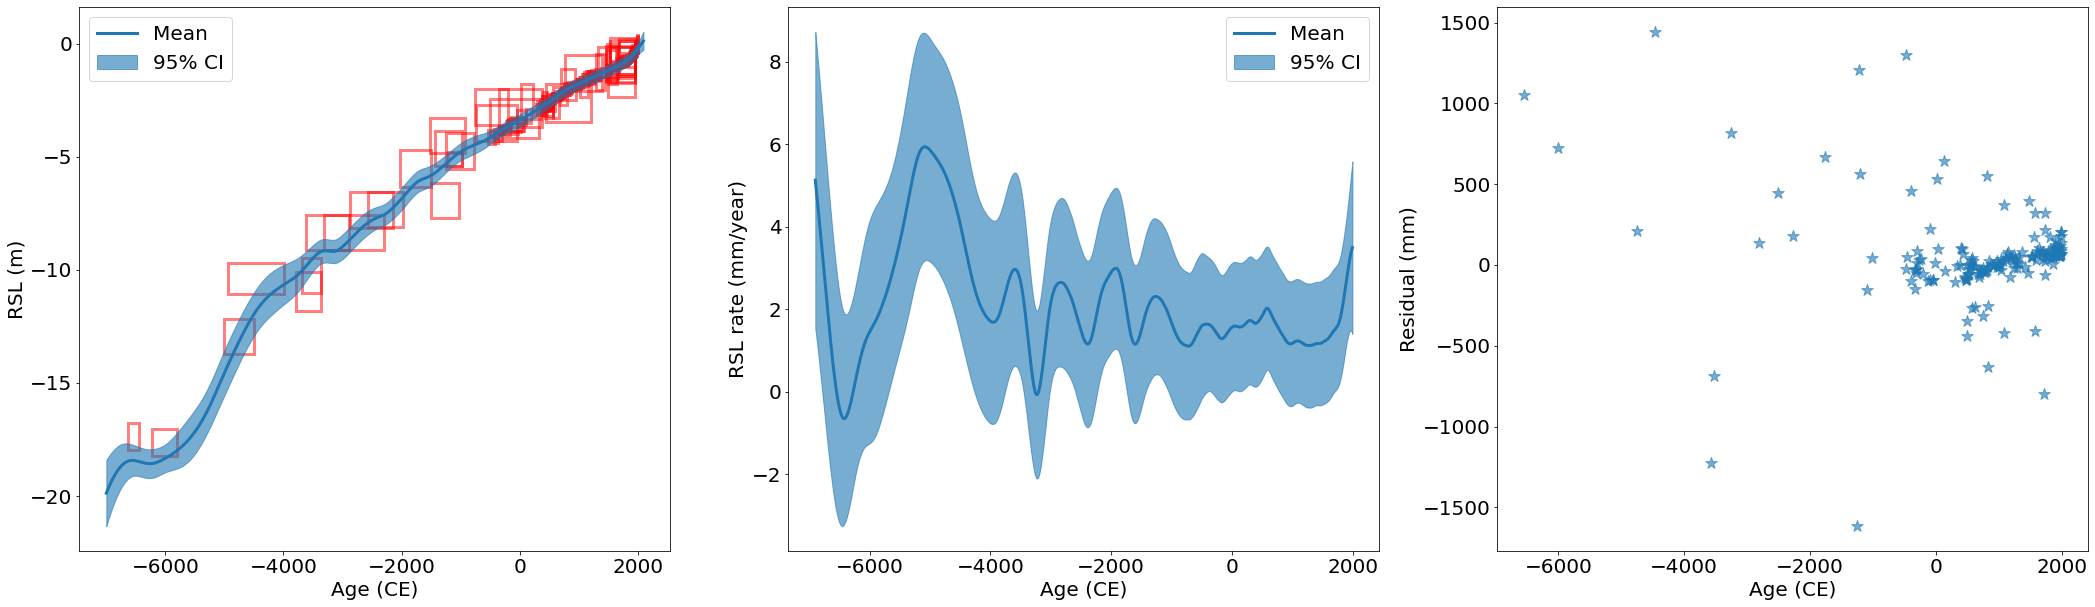

In [4]:
#generate prediction matrix
NJ_index = rsl_region==7
test_age = np.arange(-7000,2100,5)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.cpu().detach().numpy(),y_mean.cpu().detach().numpy())

#plot the prediction
axes = PSTHM.plot_tem_regreesion(age[NJ_index],y[NJ_index],age_sigma[NJ_index],y_sigma[NJ_index],test_age,y_mean.detach().numpy(),y_std.detach().numpy(),
                          rsl_time,rsl_rate,rsl_rate_sd )


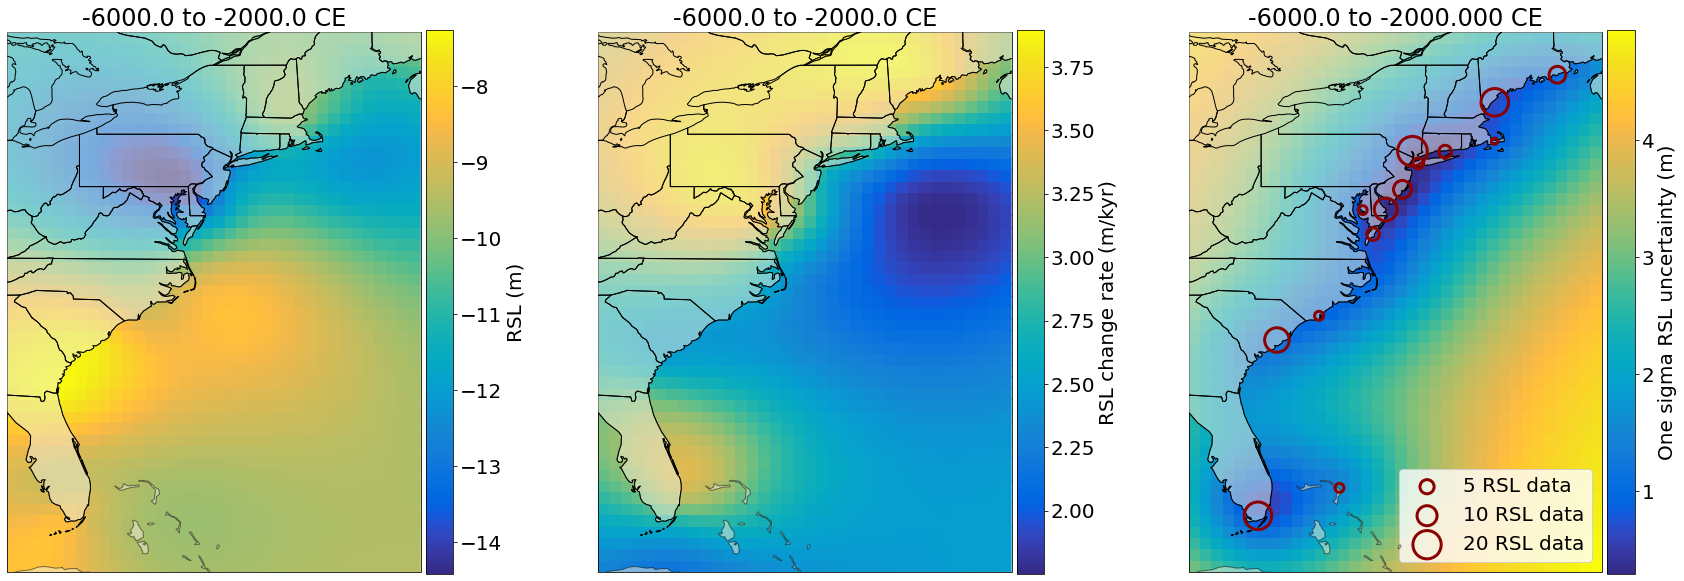

In [14]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
#from 10000 to 8000 with 500 years interval, don't use over small time interval, otherwise the prediction will be very slow
#and the required RAM will be pretty large 
time_mat = np.arange(-6000,-1900,4000) 
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)

y_mean, y_var = gpr(pred_matrix, full_cov=True)

PSTHM.plot_spatial_rsl_range(pred_matrix,y_mean,y_var,rsl_lon,rsl_lat,age,rsl_region,cmap=parula,plot_site=True)


#### Kernel decompositions


In [17]:
NJ_index = rsl_region==7
test_age = np.arange(-10000,2100,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix, full_cov=True)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern1
regional_linear_kernel = gpr.kernel.kern0.kern0.kern0.kern0
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1
local_nl_kernel = gpr.kernel.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep,local_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[global_kernel,regional_linear_kernel,regional_nl_kernel,local_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()

local_nl_mean,local_nl_var = local_nl_dep
local_nl_std = local_nl_var.diag().sqrt()


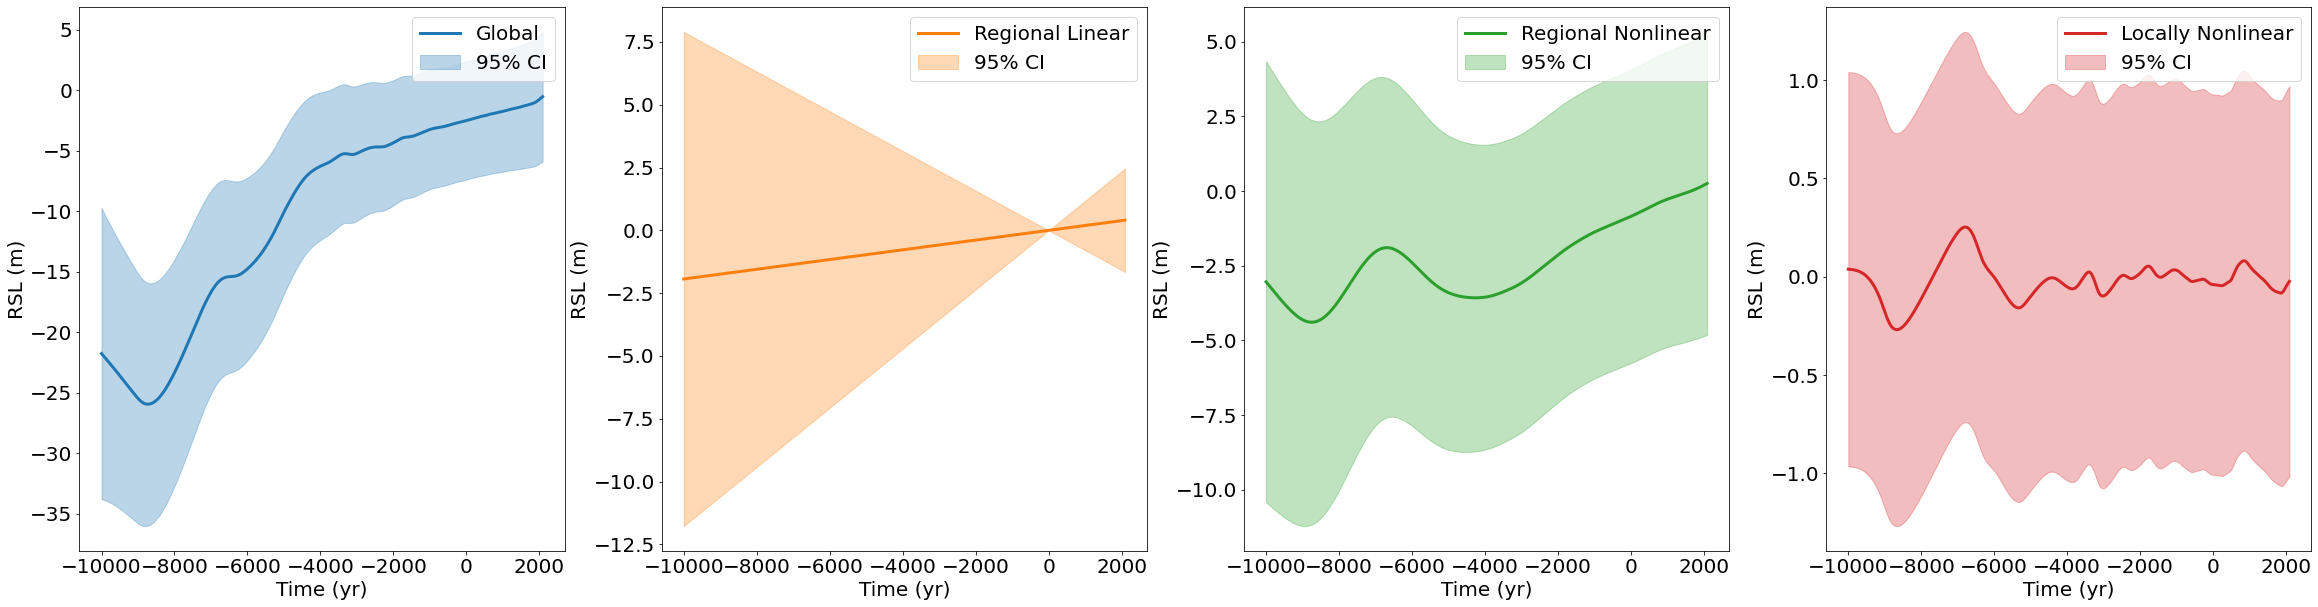

In [18]:
plt.figure(figsize=(40,10))
plt.subplot(141)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(142)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,local_nl_mean.detach().numpy(),'C3',linewidth=3,label='Locally Nonlinear')
plt.fill_between(test_age,local_nl_mean.detach().numpy()-2*local_nl_std.detach().numpy(),local_nl_mean.detach().numpy()+2*local_nl_std.detach().numpy(),color='C3',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend();

In [25]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
pred_matrix = PSTHM.gen_pred_matrix([-10000],lat_matrix,lon_matrix)
pred_matrix2 = PSTHM.gen_pred_matrix([2000],lat_matrix,lon_matrix)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern1
regional_linear_kernel = gpr.kernel.kern0.kern0.kern0.kern0
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1
local_nl_kernel = gpr.kernel.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
reigonal_linear_dep,regional_nl_dep,local_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[regional_linear_kernel,regional_nl_kernel,local_nl_kernel])
reigonal_linear_dep2,regional_nl_dep2,local_nl_dep2 = PSTHM.decompose_kernels(gpr,pred_matrix2,[regional_linear_kernel,regional_nl_kernel,local_nl_kernel])

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_mean2,regional_linear_var2 = reigonal_linear_dep2
regional_linear_std = regional_linear_var.diag().sqrt()
regional_linear_std2 = regional_linear_var2.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_mean2,regional_nl_var2 = regional_nl_dep2
regional_nl_std = regional_nl_var.diag().sqrt()
regional_nl_std2 = regional_nl_var2.diag().sqrt()

local_nl_mean,locall_nl_var = local_nl_dep
local_nl_mean2,local_nl_var2 = local_nl_dep2
local_nl_std = local_nl_var.diag().sqrt()
local_nl_std2 = local_nl_var2.diag().sqrt()


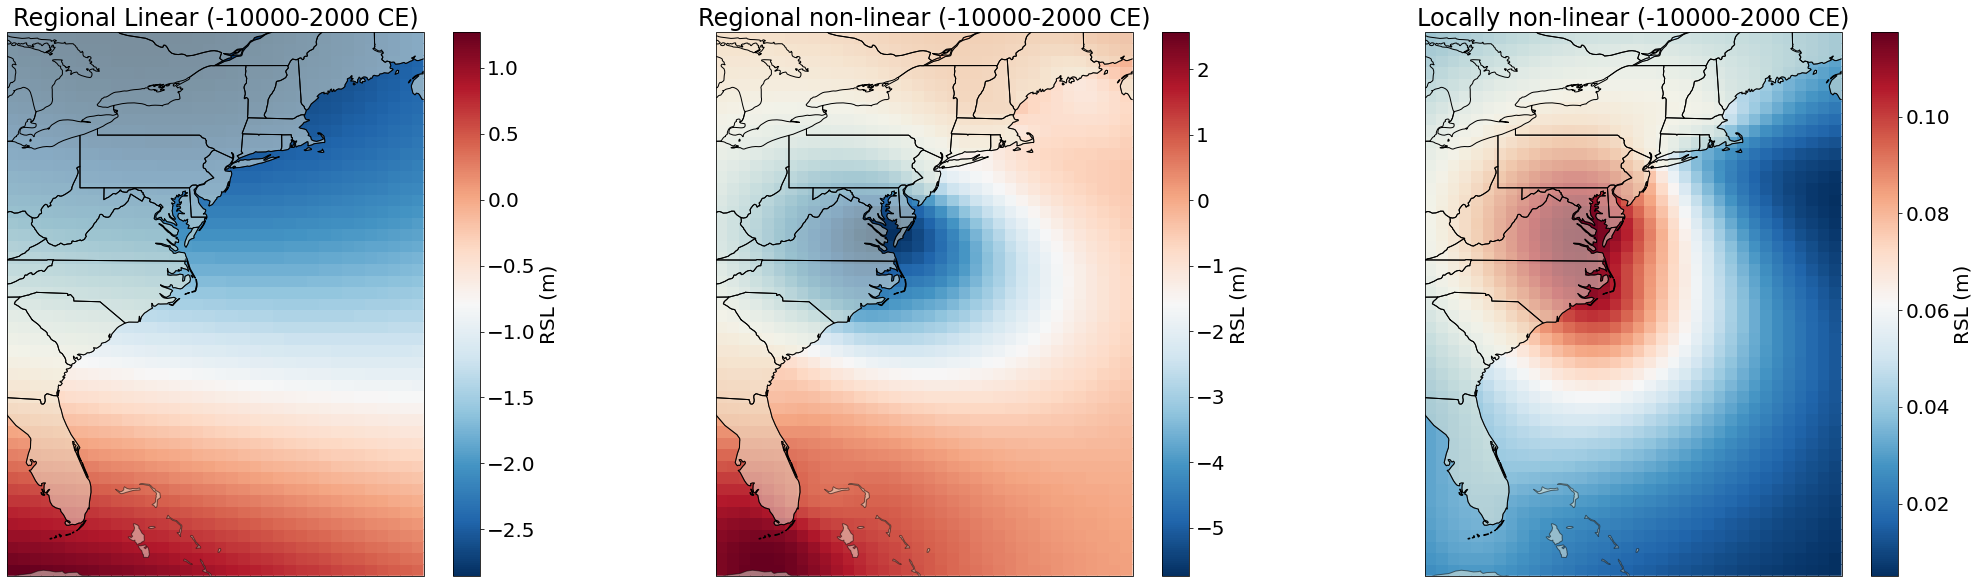

In [26]:
plt.figure(figsize=(36,10))
ax2 = plt.subplot(131,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(regional_linear_mean-regional_linear_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Regional Linear (-10000-2000 CE)')


ax2 = plt.subplot(132,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)

im = ax2.pcolor(lon_mat,lat_mat,(regional_nl_mean-regional_nl_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Regional non-linear (-10000-2000 CE)')

ax2 = plt.subplot(133,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)

im = ax2.pcolor(lon_mat,lat_mat,(local_nl_mean-local_nl_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Locally non-linear (-10000-2000 CE)');

By decomposing different STGP kernels, we can start to identify some phyiscal processes of postglacial sea-level change. We can see that regional linear kernel cause sea-level fall in the north and sea-level rise in the south, which can relate to glacial isostatic adjustment, tectonic and sediment compaction. The regional and locally non-linear terms usually used to describe ocean/atmosphere dynamics and static equilibrium “fingerprint” effects. 

### 2. STGP with a single physical model for Holocene sea-level data

As suggested by many paleo sea-level studies that the majority of sea-level change from the Last Glacial Maximum (~21,000 years ago) can be explained by ice-ocean mass exchange induced gravitational, rotational and deformational (GRD) effects on sea-level change, whcih can be modelled by a glacial isostatic adjustment (GIA) model. 

In this case, we can write our model as:
$$
p(f| \Theta_{s},\Theta_{g},f) \sim GP(GIA(X| \Theta_{g}),k_{combined}(X,X'))
$$
where $\Theta_{g}$ indicates GIA model parameters, including global ice history and Earth rheology; and GIA(X) indicates GIA model output for specific location and time, which can be interpreted as a interpolation function producing sea-level predictions for any given location and time. 

Let's try to predict sea level based on ICE_7G ice model as VM5 Earth rheology model, which can be downloaded [here](https://www.atmosp.physics.utoronto.ca/~peltier/data.php). You can see the GIA model prediction on global sea level on the figure below. Based on physical simulation, we can see more pattern of sea-level change for regional far-away from sea-level data. Although physical model can predict global sea level, the predicted sea-level can also fail to explain the observed sea-level data due to missing physical law, under constrained physical parameters etc... This can be evident when we check the data-model misfit in the right figure below.


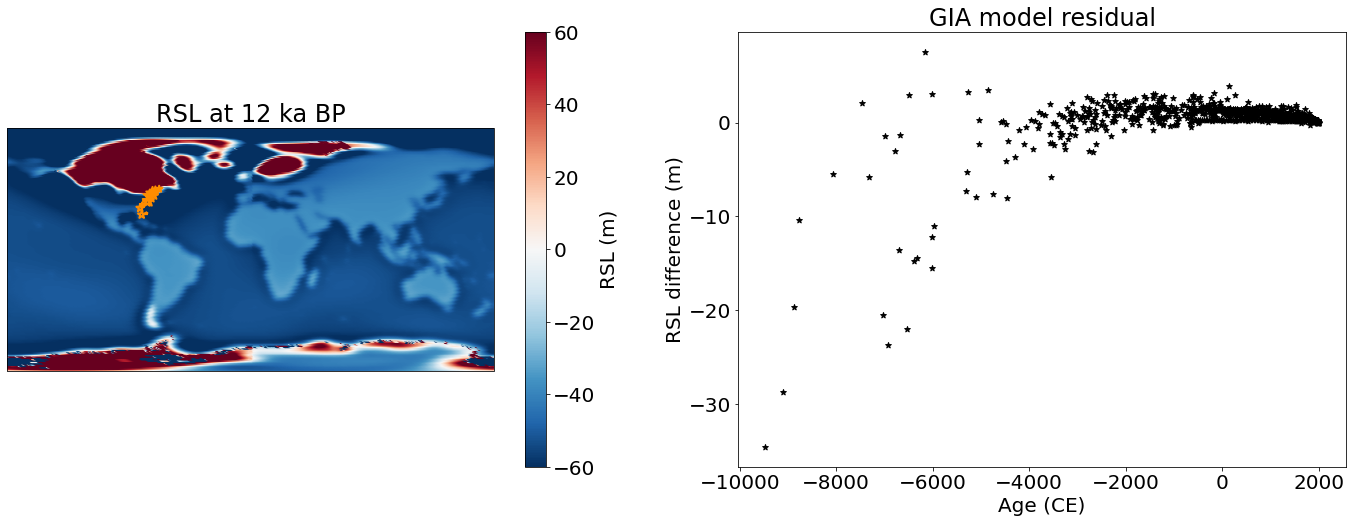

In [20]:
lat = np.arange(-89.5,90,1)
lon = np.arange(0.5,360,1)
times = np.arange(0,13)
lon_matrix_GIA,lat_matrix_GIA = np.meshgrid(lon,lat)
ice7g_rsl = np.load('ice7g_rsl.npy')
#select which time to visualize
time_index = 12
#-------Interpolate GIA model to RSL locations
from scipy.interpolate import RegularGridInterpolator as rgi
#transfer GIA model age to CE
time_CE = -(times*1000-1950)+67
time_mat,lat_mat,lon_mat = np.meshgrid(time_CE,lat,lon)
#interpolate GIA model
ice7g_interp = rgi((time_CE[::-1],lat,lon), ice7g_rsl[::-1])
#transfer longitude from -180-180 to 0-360
X_new = torch.clone(X)
X_new[:,2]+=360
ice7g_pred = ice7g_interp(X_new)

#---------------------------------------------------------
fig = plt.figure(figsize=(24,8))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())

im = ax2.scatter(lon_matrix_GIA,lat_matrix_GIA,c = ice7g_rsl[time_index],cmap='RdBu_r',zorder=0,vmax = 60,vmin=-60)
ax2.scatter([np.mean(rsl_lon[x]) for x in rsl_region_index], [np.mean(rsl_lat[x]) for x in rsl_region_index],
           transform=ccrs.PlateCarree(),s=[len(x)*1 for x in rsl_region_index],marker='*',facecolor='none',ec='darkorange',
           linewidth=2)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('RSL at {:} ka BP'.format(time_index))

plt.subplot(122)
plt.scatter(X_new[:,0],ice7g_pred-y.cpu().detach().numpy(),c='k',marker='*')
plt.xlabel('Age (CE)')
plt.ylabel('RSL difference (m)')
plt.title('GIA model residual');

In this case, we can use use GP model based on a physical model to improve the performance of paleo sea-level. To implement GP with a single GIA model, we are essentially training the GP model with the GIA model residual (instead of original RSL data). As GIA model can be used to describe global and regional linear trend, we can re-write our combined kernel to:
$$
k_{combined}(X,X') = k_{localNL}(X,X') + k_{whitenoise}(t,t')
$$


In [57]:
# st = time.time() 

# pyro.clear_param_store()

# #define locally non-linar spatio-temporal kernel
# local_nl__temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(20000.)))
# local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5**2), torch.tensor(30.**2)))
# local_nl__spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
# local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.3)))
# local_nl_kernel = gp.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

# #define whitenoise kernel
# whitenoise_kernel = gp.kernels.WhiteNoise(input_dim=1)
# whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.1**2),torch.tensor(100.)))

# #combine all kernels

# combined_sp_kernel = gp.kernels.Sum(local_nl_kernel,whitenoise_kernel)

# y_residual = torch.tensor(y.cpu().detach().numpy() - ice7g_pred).double()
# gpr = PSTHM.GPRegression_V(X_new, y_residual, combined_sp_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

# #Empirical bayes optimization, default iteration is 1000
# gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma=age_sigma,num_iteration=300,lr=0.3,decay_r = 0.8,step_size=50)

# axes = PSTHM.plot_track_list(track_list)
# et = time.time() # get the end time

# # get the execution time
# elapsed_time = et - st
# print('Execution time: {:3.3f} s'.format( elapsed_time))

# # #----Save and load the trained model----
# torch.save(gpr, '../../Trained_Models/7G_GP_model')
gpr = torch.load('../../Trained_Models/7G_GP_model')
print('local non-linear kernel lengthscale: {:3.3f}, s_lengthscale {:3.3f}, variance: {:3.3f}'.format(gpr.kernel.kern0.kern0.lengthscale,
                                                                                                      gpr.kernel.kern0.kern1.s_lengthscale,gpr.kernel.kern0.kern0.variance))


local non-linear kernel lengthscale: 6920.277, s_lengthscale 0.100, variance: 109.606


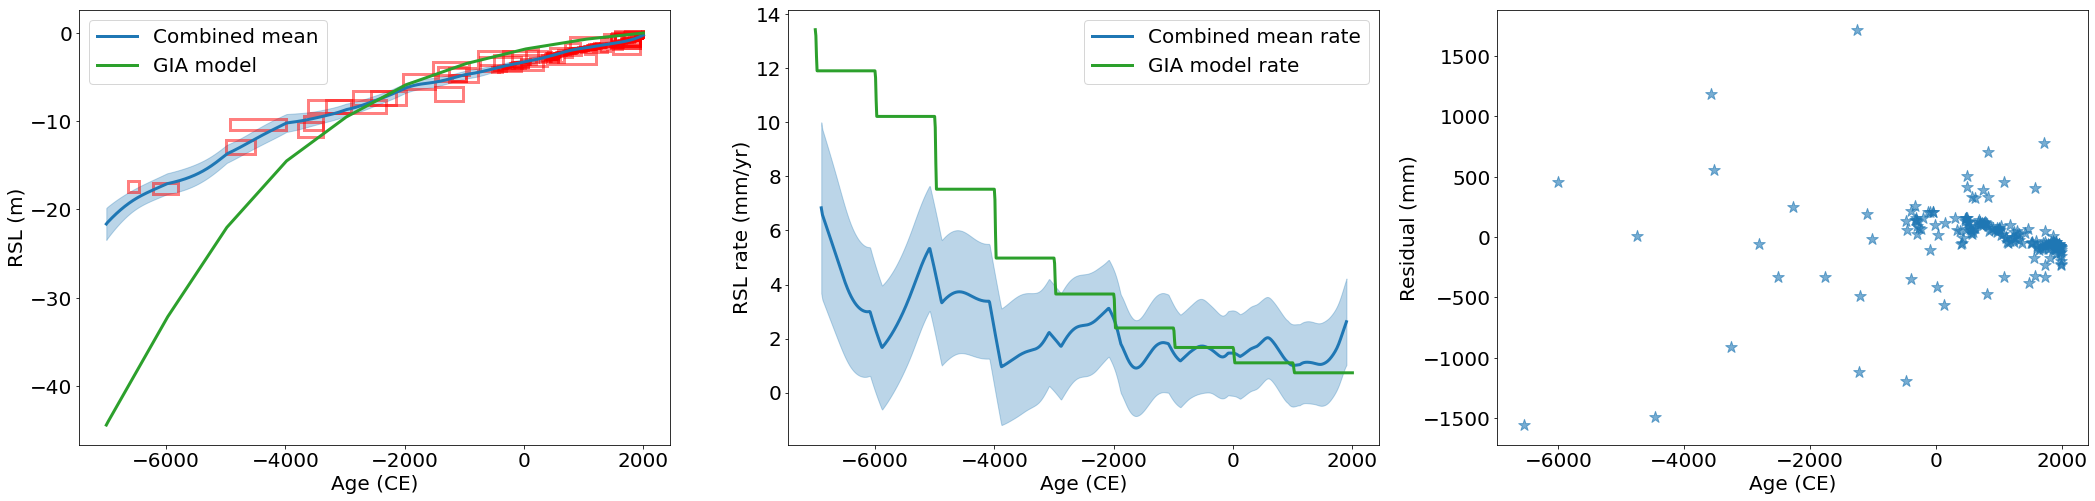

In [58]:
#generate prediction matrix
NJ_index = rsl_region==7
test_age = np.arange(-7000,2010,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True)
pred_matrix[:,2]+=360
GIA_pred = torch.tensor(ice7g_interp(pred_matrix))
y_combined= y_mean + GIA_pred
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.cpu().detach().numpy(),y_combined.cpu().detach().numpy())
GIA_model_rate = np.gradient(GIA_pred,test_age)

#plot the prediction
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X[:,0][NJ_index],y[NJ_index], age_sigma[NJ_index]*2,y_sigma[NJ_index]*2,ax=ax)
plt.plot(test_age,y_combined.detach().numpy(),'C0',linewidth=3,label='Combined mean')
plt.fill_between(test_age,y_combined.detach().numpy()-2*y_std.detach().numpy(),y_combined.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3)
plt.plot(test_age,GIA_pred,'C2',linewidth=3,label='GIA model')
plt.legend()

plt.subplot(132)
plt.plot(rsl_time,rsl_rate*1000,'C0',linewidth=3,label='Combined mean rate')
plt.fill_between(rsl_time,(rsl_rate-2*rsl_rate_sd)*1000,(rsl_rate+2*rsl_rate_sd)*1000,color='C0',alpha=0.3)
plt.plot(test_age,GIA_model_rate*1000,'C2',linewidth=3,label='GIA model rate')
plt.legend()
plt.ylabel('RSL rate (mm/yr)')
plt.xlabel('Age (CE)')

plt.subplot(133)
f = interpolate.interp1d(test_age,y_combined.detach().numpy())
residual = f(X[:,0][NJ_index])-y[NJ_index].detach().numpy()
plt.scatter(X[:,0][NJ_index],residual*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)');

We can see that by combining the GIA and GP models, the final predictions now are influenced by physical model and observational data, hence, we often refer this approach as a [data assimilation](https://en.wikipedia.org/wiki/Data_assimilation) approach. Becuase GIA model is controlled by ice history, the resolution of which is typically very low, using GP can effectively help us to understand sea-level change with better temporal resolution.

We can further experience the effect of incorporating a GP with a GIA model when we doing spatial analysis. Let's plot the spatial distribution of RSL. 



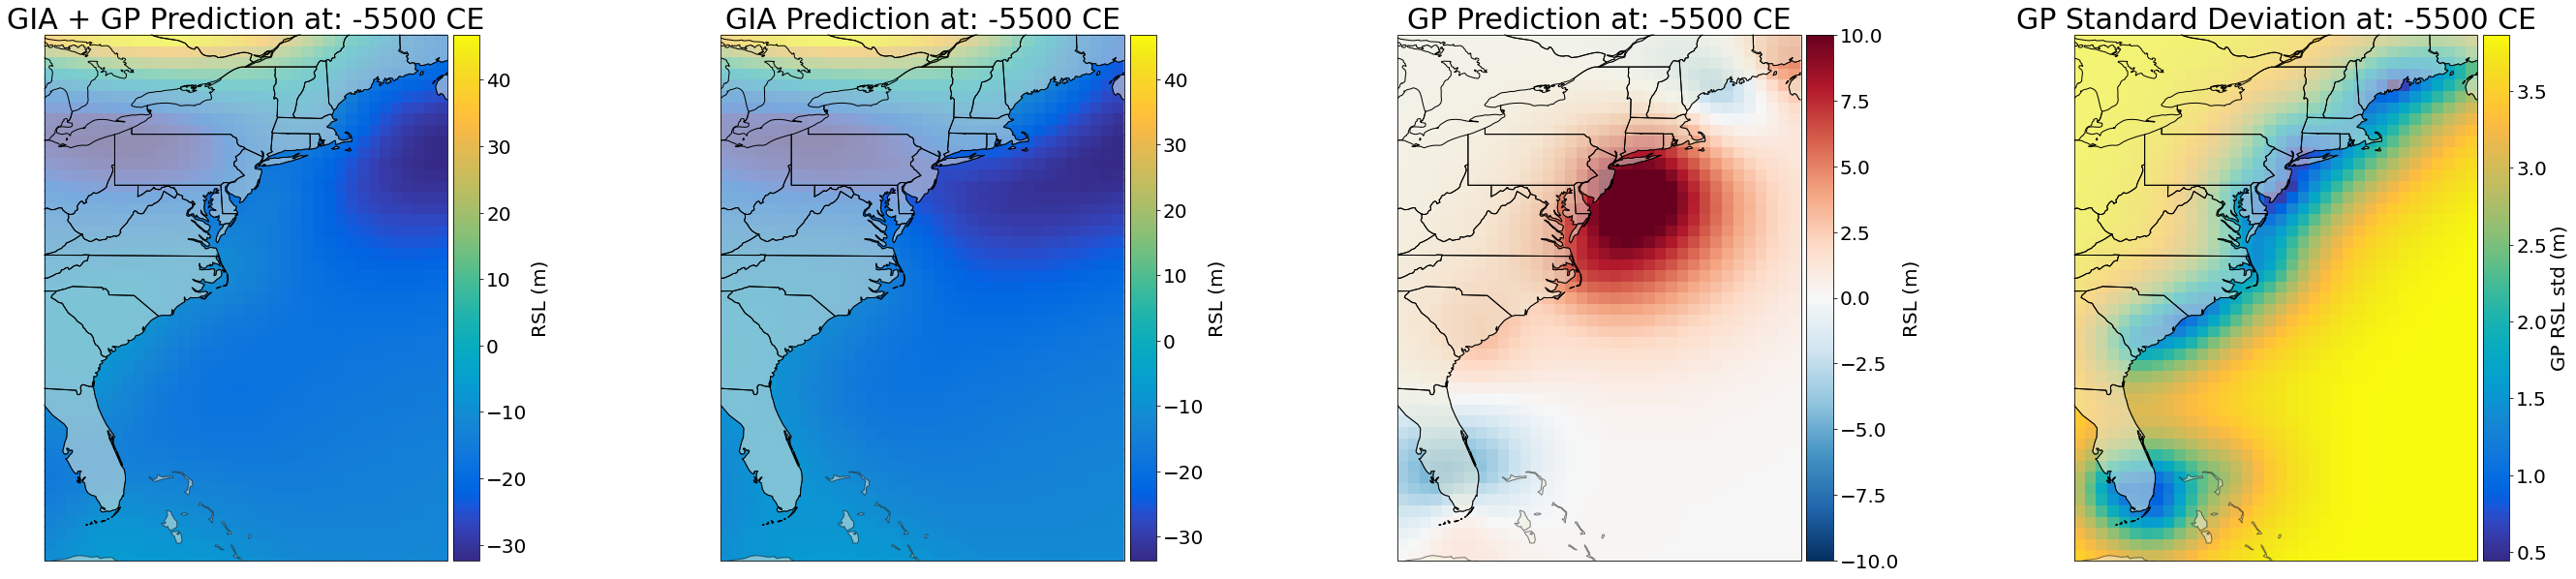

In [59]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
time_mat = np.array([-5500]) 
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
pred_matrix[:,2]+=360
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()

GIA_pred = torch.tensor(ice7g_interp(pred_matrix))
y_combined= y_mean + GIA_pred

#------------plot -----------------
plt.figure(figsize=(48,10))
ax2 = plt.subplot(141,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_combined.detach().numpy().reshape([48,37]),transform=ccrs.PlateCarree(),cmap=parula,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA + GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(142,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,GIA_pred.reshape([48,37]),transform=ccrs.PlateCarree(),cmap=parula,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(143,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_mean.detach().numpy().reshape([48,37]),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=10,vmin=-10,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(144,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_std.detach().numpy().reshape([48,37]),transform=ccrs.PlateCarree(),cmap=parula,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('GP RSL std (m)')
ax2.set_title('GP Standard Deviation at: {:} CE'.format(time_mat[0]),fontsize=30);

From the temporal analysis above we can find that the GIA prediction around New Jersey shows a RSL much lower than the observastions, in this case, GP predicts a strongly positive sea-level around New Jersey. Likewise, GIA prediction around Florida shows a RSL higher than the observations, therefore, GP model refines the sea level there. 

Compared to GP-only model, this combined approach shows a spatial sea-level pattern that is more consistent with sea-level physics. 

### 3. STGP with multiple physical models for Holocene sea-level data 

Given the hugh uncertainty in ice history and Earth rheology, using one GIA model output to describe the GRD signal is often not appropriate. To improve this, we can use probablistic approach to combined multiple GIA model together, which is introduced in Tutorial 2. Let's try to use ice model from [Gowan et al., 2021](https://www.nature.com/articles/s41467-021-21469-w) with 1-D Earth rheology model with 71 km lithosphere, 0.3 and 70 x 10 $^{21}$ Pa s upper and lower mantle viscosity to describe an alternative sea-level pattern. 

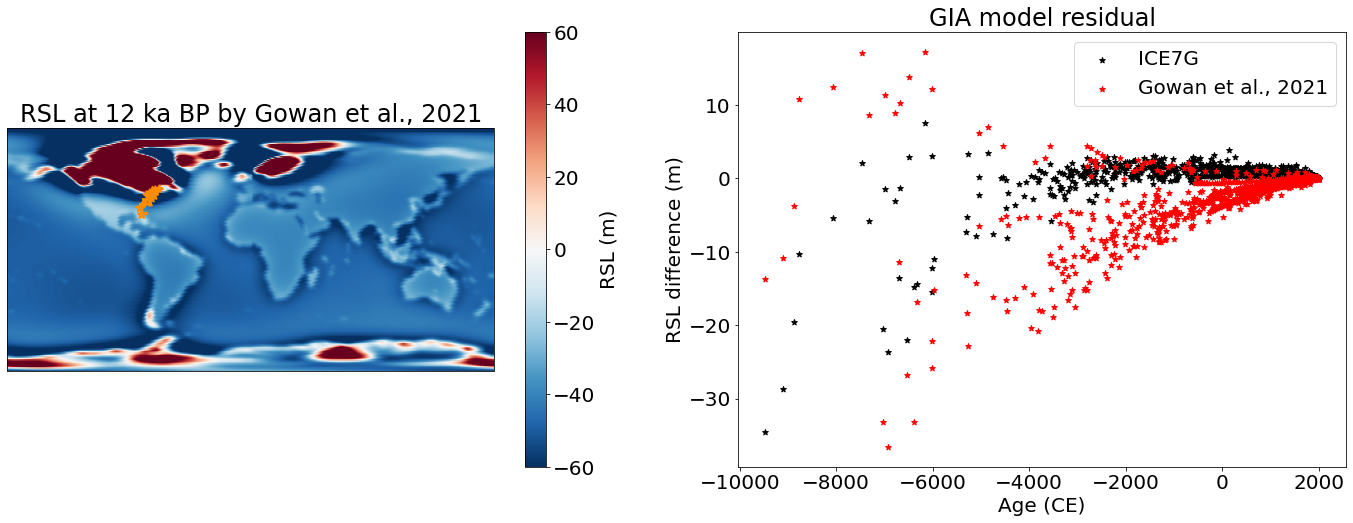

In [60]:
gowan_rsl = np.load('gowan_rsl.npy')
#interpolate GIA model
gowan_interp = rgi((time_CE[::-1],lat,lon), gowan_rsl[::-1])
#transfer longitude from -180-180 to 0-360
gowan_pred = gowan_interp(X_new)

time_index = 12 
#---------------------------------------------------------
fig = plt.figure(figsize=(24,8))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())

im = ax2.scatter(lon_matrix_GIA,lat_matrix_GIA,c = gowan_rsl[time_index],cmap='RdBu_r',zorder=0,vmax = 60,vmin=-60)
ax2.scatter([np.mean(rsl_lon[x]) for x in rsl_region_index], [np.mean(rsl_lat[x]) for x in rsl_region_index],
           transform=ccrs.PlateCarree(),s=[len(x)*1 for x in rsl_region_index],marker='*',facecolor='none',ec='darkorange',
           linewidth=2)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('RSL at {:} ka BP by Gowan et al., 2021'.format(time_index))

plt.subplot(122)
plt.scatter(X_new[:,0],ice7g_pred-y.cpu().detach().numpy(),c='k',marker='*',label='ICE7G')
plt.scatter(X_new[:,0],gowan_pred-y.cpu().detach().numpy(),c='r',marker='*',label='Gowan et al., 2021')

plt.xlabel('Age (CE)')
plt.ylabel('RSL difference (m)')
plt.title('GIA model residual')
plt.legend();

You can clearly see some difference between these two models, where sea-level prediction by Gowan et al., 2021 significantly underestimate the true sea level change, which can be a result of Earth rheology model used here is not suitable for this ice model. But Let's try to predict GIA-induced sea-level change as in tutorial 2:
$$
f_{GIA}(x,t) = s \times \sum_{p=1}^{n}w_{i}GIA(x,t| I_{p},E_{p})
$$

where $w_{p}$ indicates weighted parameters for each physical model set and $n$ denotes the number of tested physical parameters:
$$
w_{p} \sim Dir(1)\\
$$
where $Dir$ indicates a a Dirichlet distribution, which is used to generate random weighting factors that fulfil the conditions $\sum_{p=1}^{n} w_{p} = 1$ and $w_{p} >0$; 1 is a hyperparameter that describes the concentration of random samples.

$s$ is a sclaring parameter to scale the GIA preidction:
$$
s \sim N(1,0.15)
$$

To input GIA models as mean function for GP model, we need to input the interpolation functions of GIA models to GP model. Check the example code below!

**P.S.** The default code does not train the model, instead, it will load the trained model, which is much faster. If you want to try to train it on your own computer, just de-comment the code. 

In [61]:
# from pyro.infer import MCMC, NUTS

# st = time.time() 

# pyro.clear_param_store()

# #define locally non-linar spatio-temporal kernel
# local_nl__temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(20000.)))
# local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5**2), torch.tensor(30.**2)))
# local_nl__spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
# local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.3)))
# local_nl_kernel = gp.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

# #define whitenoise kernel
# whitenoise_kernel = gp.kernels.WhiteNoise(input_dim=1)
# whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.1**2),torch.tensor(100.)))

# #combine all kernels
# combined_sp_kernel = gp.kernels.Sum(local_nl_kernel,whitenoise_kernel)

# #----define mean function
# # the first number (2) here means there are 2 GIA models to interpolate
# mean_fn = PSTHM.GIA_ensemble(2,[gowan_interp,ice7g_interp])
# mean_fn.set_prior('w',dist.Dirichlet(torch.ones(2)))
# mean_fn.set_prior('s',dist.Normal(torch.tensor(1.0),torch.tensor(0.15)))

# gpr = PSTHM.GPRegression_V(X_new, y, combined_sp_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5,mean_function=mean_fn)

# #Empirical bayes optimization, default iteration is 1000
# gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma=age_sigma,num_iteration=500,lr=0.5,decay_r = 0.8,step_size=50)
# axes = PSTHM.plot_track_list(track_list)

# #calulate log likelihood of the model prediction

# et = time.time() # get the end time

# # get the execution time
# elapsed_time = et - st
# print('Execution time: {:3.3f} s'.format( elapsed_time))

# torch.save(gpr, '../../Trained_Models/multi_GIA_GP_model')
pyro.clear_param_store()
gpr = torch.load('../../Trained_Models/multi_GIA_GP_model')
print('local non-linear kernel lengthscale: {:3.3f}, s_lengthscale {:3.3f}, variance: {:3.3f}'.format(gpr.kernel.kern0.kern0.lengthscale,
                                                                                                      gpr.kernel.kern0.kern1.s_lengthscale,gpr.kernel.kern0.kern0.variance))
print('w_0: {:3.2f}, w_1: {:3.2f}'.format(*gpr.mean_function.w))
print('s: {:3.2f}'.format(gpr.mean_function.s))

local non-linear kernel lengthscale: 3686.481, s_lengthscale 0.050, variance: 14.963
w_0: 0.44, w_1: 0.56
s: 0.53


You can see that, two GIA gains similar weights factors with a very low scaling parameter 0.5, indicating it srinks down the original GIA prediction by almost a half. Let's see how it impact on local RSL prediction:

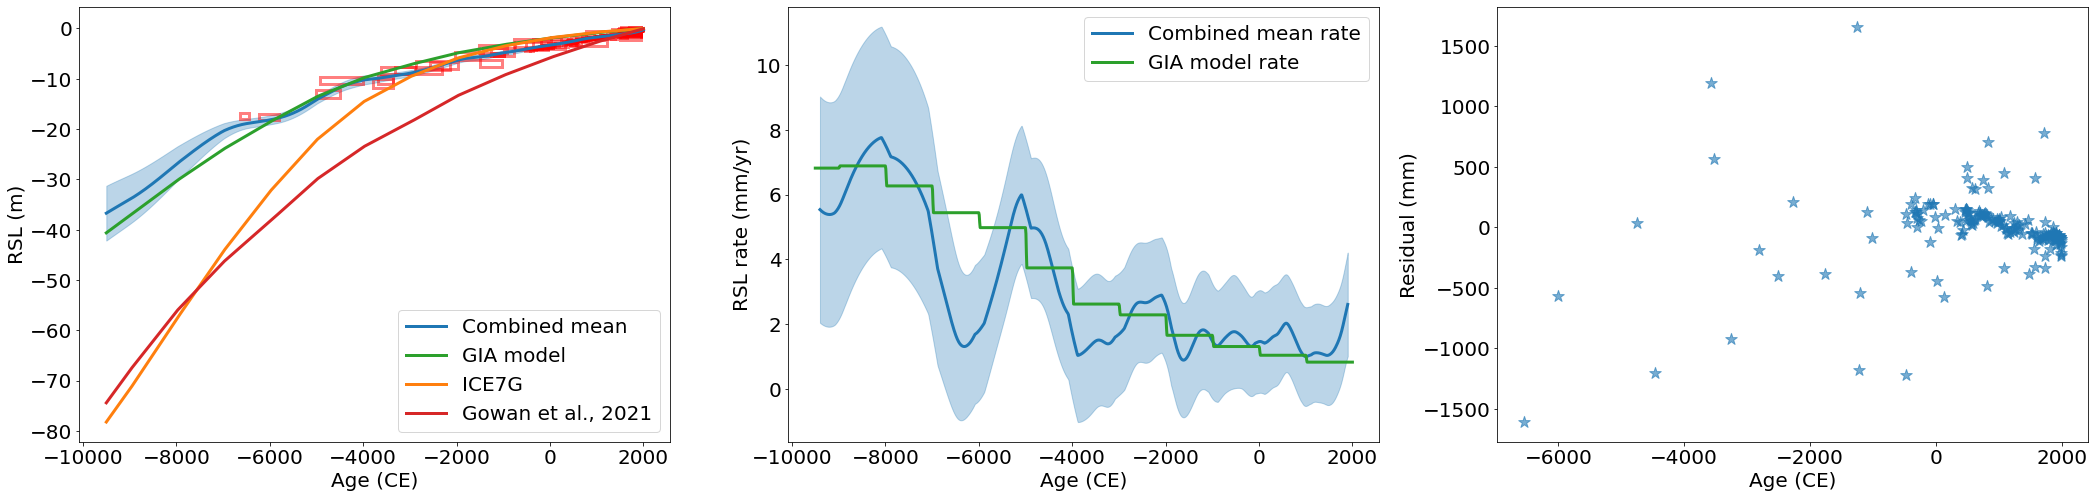

In [82]:
#generate prediction matrix
#Change the number here to visulize RSL at different sites!
#this range can be between 0-16
NJ_index = rsl_region==7
#------------------------------------------------------------

test_age =  np.arange(-9500,2010,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
pred_matrix[:,2]+=360
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.cpu().detach().numpy(),y_mean.cpu().detach().numpy())
mean_GIA = gpr.mean_function(pred_matrix)
GIA_model_rate = np.gradient(mean_GIA.detach().numpy(),test_age)

#plot the prediction
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X[:,0][NJ_index],y[NJ_index], age_sigma[NJ_index]*2,y_sigma[NJ_index]*2,ax=ax)
plt.plot(test_age,y_mean.detach().numpy(),'C0',linewidth=3,label='Combined mean')
plt.fill_between(test_age,y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3)
plt.plot(test_age,mean_GIA.detach().numpy(),'C2',linewidth=3,label='GIA model')
plt.plot(test_age,ice7g_interp(pred_matrix),'C1',linewidth=3,label='ICE7G')
plt.plot(test_age,gowan_interp(pred_matrix),'C3',linewidth=3,label='Gowan et al., 2021')


plt.legend()


plt.subplot(132)
plt.plot(rsl_time,rsl_rate*1000,'C0',linewidth=3,label='Combined mean rate')
plt.fill_between(rsl_time,(rsl_rate-2*rsl_rate_sd)*1000,(rsl_rate+2*rsl_rate_sd)*1000,color='C0',alpha=0.3)
plt.plot(test_age,GIA_model_rate*1000,'C2',linewidth=3,label='GIA model rate')
plt.legend()
plt.ylabel('RSL rate (mm/yr)')
plt.xlabel('Age (CE)')

plt.subplot(133)
f = interpolate.interp1d(test_age,y_mean.detach().numpy())
residual = f(X[:,0][NJ_index])-y[NJ_index].detach().numpy()
plt.scatter(X[:,0][NJ_index],residual*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)');


You can that, unlike using one GIA model above, here we optimize the GIA prediction along with GP, in this case, GIA model prediction fits much better with RSL data here. And we can now see the low scaling factor is due to both GIA model predicts much lower sea level than observation. And let's see how does it impact the spatial prediction.

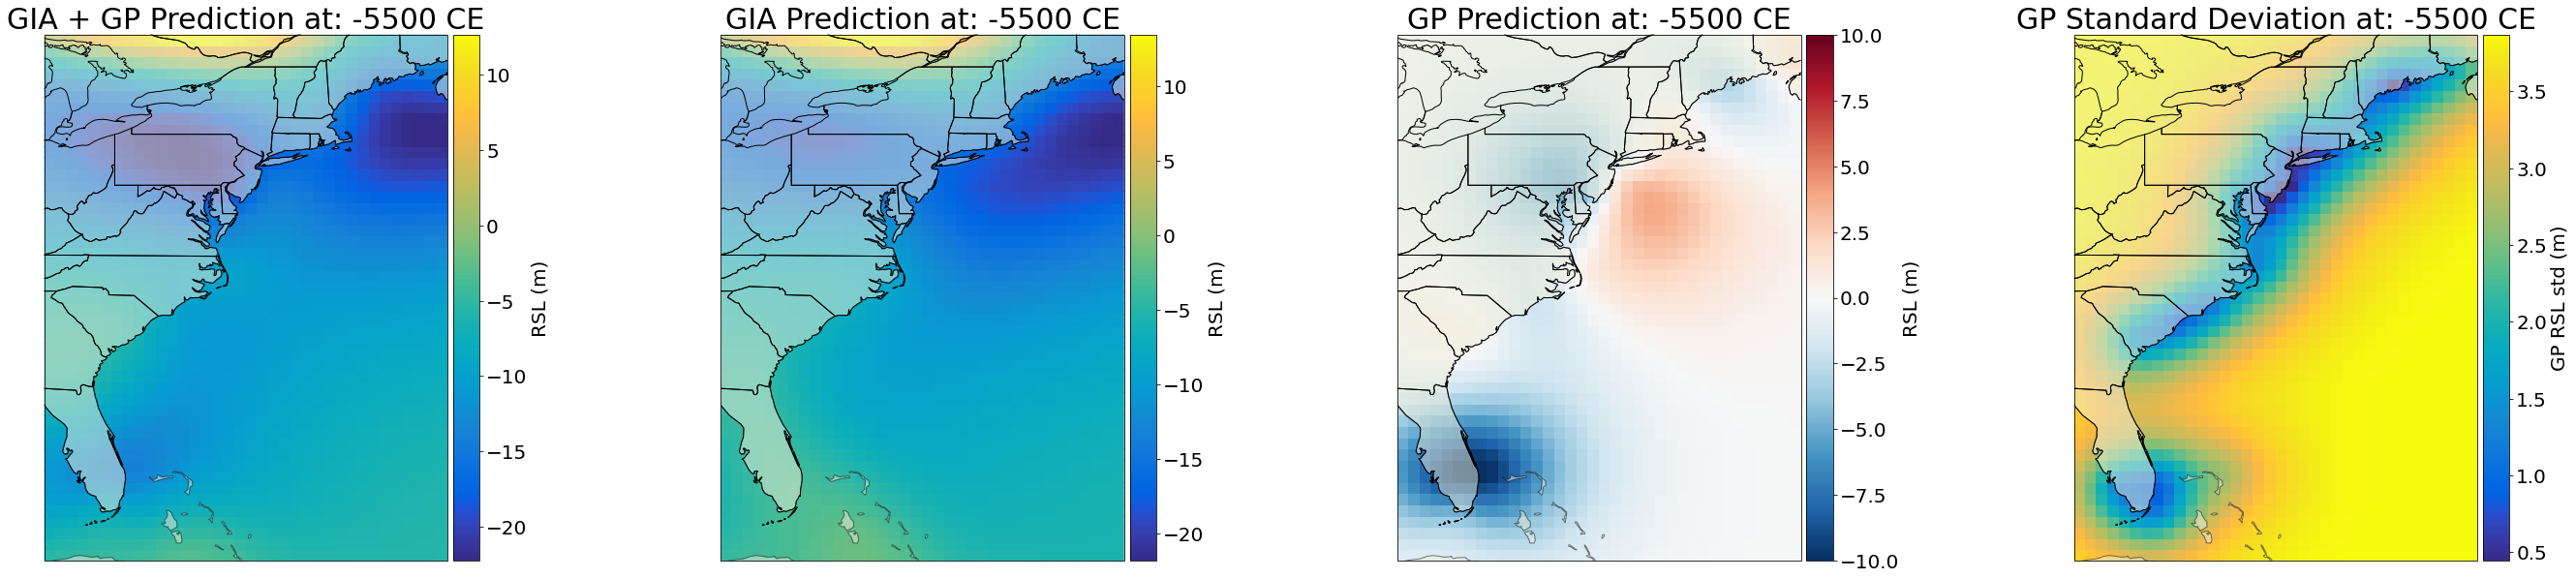

In [84]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
#Change the number here to visulize RSL at different time!!
time_mat = np.array([-5500]) 
#---------------------------------------------------------------------
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
pred_matrix[:,2]+=360
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()
#------------plot -----------------
plt.figure(figsize=(48,10))
ax2 = plt.subplot(141,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_mean.detach().numpy().reshape([48,37]),transform=ccrs.PlateCarree(),cmap=parula,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA + GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(142,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,gpr.mean_function(pred_matrix).detach().numpy().reshape([48,37]),transform=ccrs.PlateCarree(),cmap=parula,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(143,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,(y_mean-gpr.mean_function(pred_matrix)).detach().numpy().reshape([48,37]),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=10,vmin=-10,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(144,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_std.detach().numpy().reshape([48,37]),transform=ccrs.PlateCarree(),cmap=parula,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('GP RSL std (m)')
ax2.set_title('GP Standard Deviation at: {:} CE'.format(time_mat[0]),fontsize=30);

You can see that, because GIA models (i.e., GP mean function) fits better to the observations, GP kernel predictions are relatively smaller compared with the resulting using one GIA model above. Therefore, we can now optimize the GIA model performance and fill out the rest with kernel predictions, which is good because GIA model represent a well-known physics knowledge of sea-level change. 

Importantly, you can use any number of physical model as you wish (not restricted to 2), so you can also calibrate physical model parameter along with the GP framework!


Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.